<hr/>

# Dependencies

<hr/>

In [33]:
# Calculation Dependencies

import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

# Plotting Dependencies
from sklearn import datasets
import matplotlib.pyplot as plt

# Preprocessing dependencies
import csv
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# # maybe useful in future
# from sklearn.metrics import silhouette_samples, silhouette_score
# from mpl_toolkits.mplot3d import Axes3D

<hr/>

#  Helper Functions



1.   plot_features - 2d plotting any data array with shape (num_examples, num_features)
2.   PCA_iterative - PCA dimensionality reduction based on desired threshold for the explanation of variance
3.   kmeans_clustering - performs kmeans clustering based on desired number of clusters 



<hr/>

In [34]:
# function that plots every feature against each other
def plot_features(data, labels):
  """
  input args:
    data = numpy array where rows are number of examples and columns are number of features

  
  rows are in order by features 1, 2, ...num_features-1 
  plotted against every other features that hasn't already been plotted
  e.g. row 1 is feature 1 versus 2, 1 versus 3, ...,1 versus num_features
  e.g. row 5 is features 5 versus 6, feature 6 versus 7, ..., 5 versus num_features
  """
  num_feature = data.shape[1]
  plt.figure(figsize=(num_feature*4,num_feature*4));
  for i in range(num_feature):
    for j in range(i+1,num_feature):
      plt.subplot(num_feature,num_feature,i*num_feature+j-i+1)
      plt.scatter(data[:,i],data[:,j],c=labels, label = ('feature ', (i+1), 'versus ', (j+1)), cmap = 'coolwarm')
      plt.legend()
  plt.show()


In [35]:
# Preprocessing, note whitening is set to be true
# PCA and whitening
def PCA_iterative(data, test_data, whiten_bool = 'True', n = 0):
  """
  """

  pca = PCA(n_components = n, whiten=whiten_bool)
  B = pca.fit_transform(data) 
  C = pca.fit_transform(test_data)
  L = pca.explained_variance_
  cl=np.cumsum(L); 

  # PCA scree plot
  plt.subplot(111); 
  plt.ylabel('Total Variance');
  plt.xlabel('Principal component')
  plt.plot(np.arange(1,L.shape[0]+1),cl/cl[-1],'o-r'); 
  plt.ylim(0,None);

  B_6 = B[:,:9]
  C_6 = C[:,:9]
  print('selected first 3 components with ', cl[9]/cl[-1], ' explained variance')
  return B_6, C_6


In [36]:
def pseudolabel_unscrambler(label, cluster_label):
  """
  pseudolabels of classes get randomly assigned. This function best matches
  the pseudolabels to the original ground truth labels.
  """
  num_class = (np.max(label) + 1).astype('int')
  true_class = []
  for i in range(num_class):
    best_accuracy = 0
    for j in range(num_class):
      current_accuracy = ((cluster_label == i) == (label == j)).mean()
      if current_accuracy > best_accuracy:
        if best_accuracy == 0:
          best_accuracy = current_accuracy
          true_class.append(j)
        else:
          best_accuracy = current_accuracy
          true_class[-1] = j

  temp_cluster_label = np.copy(cluster_label)
  for i in range(len(true_class)):
    cluster_label[(temp_cluster_label == i)] = true_class[i]
  return cluster_label


In [37]:
def kmeans_clustering(num_cluster, data, test_data, label,test_label, label_bool = False, plot_bool = True):
  print('\n\ninitializing kmeans clustering')
  kmeans = KMeans(init='random', n_clusters=num_cluster, n_init=10).fit(data)
  # list of scores from kmeans method (negative sum of distance squared from cluster center)
  cluster_label, inertia = kmeans.predict(test_data), kmeans.inertia_

  if plot_bool == True:
    print('plots of clusters with true labels')
    plot_features(test_data, test_label)
  if label_bool == True:
    cluster_label = pseudolabel_unscrambler(test_label, cluster_label)
    if plot_bool == True:
      print('plots of clusters with pseudolabels')
      plot_features(test_data, cluster_label)
    accuracy = (cluster_label == test_label).mean()
    print('kmeans clustering accuracy is ', accuracy)
  print('inertia is ', inertia)
  return cluster_label


In [38]:
def gmm_clustering(num_cluster, data, test_data, label, test_label, label_bool = False, plot_bool = True):
  print('\n\ninitializing gmm clustering')
  gmm = GaussianMixture(init_params = 'random', random_state = 3, covariance_type = 'tied', n_components=num_cluster, n_init=100, max_iter = 1000).fit(data)
  cluster_label, score = gmm.predict(test_data), gmm.score(data)

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with true labels')
    plot_features(test_data, test_label)
  if label_bool == True:
    cluster_label = pseudolabel_unscrambler(test_label, cluster_label)
    if plot_bool == True:
      print('plots of clusters with pseudolabels')
      plot_features(test_data, cluster_label)
    accuracy = (cluster_label == test_label).mean()
    print('gmm clustering accuracy is ', accuracy)
  print('score is ', score)
  return cluster_label

In [39]:
def spec_clustering(num_cluster, data, test_data, label, test_label, mode, nn = 11, label_bool = False, plot_bool = True):
  print('\n\ninitializing spectral clustering with ',mode)
  if mode == 'gaussian':
    spectral = SpectralClustering(random_state = 3, n_clusters=num_cluster, affinity = 'rbf', gamma = .1).fit(data)
    # list of scores from kmeans method (negative sum of distance squared from cluster center)
    cluster_label = spectral.fit_predict(test_data)

  elif mode == 'knn':
    spectral = SpectralClustering(random_state = 3, n_clusters=num_cluster, affinity = 'nearest_neighbors', n_neighbors = nn).fit(data) 
    # list of scores from kmeans method (negative sum of distance squared from cluster center)
    cluster_label = spectral.fit_predict(test_data)

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with true labels')
    plot_features(test_data, test_label)
  if label_bool == True:
    cluster_label = pseudolabel_unscrambler(test_label, cluster_label)
    if plot_bool == True:
      print('plots of clusters with pseudolabels')
      plot_features(test_data, cluster_label)
    accuracy = (cluster_label == test_label).mean()
    print(mode, 'spectral clustering accuracy is ', accuracy)
  return cluster_label

In [40]:
# main function that performs preprocessing, kmeans clustering, gaussian mixture clustering, and spectral clustering
def experiment_main(num_cluster, data_unprocessed, test_data_unprocessed, label, test_label, preprocess=False, label_bool = False, plot_bool=True):
  # PCA preprocessing
  if preprocess == True:
    data, test_data = PCA_iterative(data_unprocessed, test_data_unprocessed, n = 30)
  else:
    data = data_unprocessed
    test_data = test_data_unprocessed
  # clustering functions
  kmeans_labels = kmeans_clustering(num_cluster, data, test_data, label, test_label, label_bool = label_bool, plot_bool = plot_bool)
  gmm_labels = gmm_clustering(num_cluster, data, test_data, label, test_label, label_bool = label_bool, plot_bool = plot_bool)
  spec_gaussian_labels = spec_clustering(num_cluster, data, test_data, label, test_label, mode = 'gaussian', label_bool = label_bool, plot_bool = plot_bool)
  spec_knn_labels = spec_clustering(num_cluster, data, test_data, label, test_label, mode = 'knn', nn = 5, label_bool = label_bool, plot_bool = plot_bool)

  # np.savetxt('kmeans_labels.csv', np.column_stack((data_id,kmeans_labels.astype('str'))), delimiter = ',',  fmt="%s")
  # np.savetxt('gmm_labels.csv', np.column_stack((data_id,gmm_labels.astype('str'))),delimiter = ',',  fmt="%s")
  # np.savetxt('spec_gaussian_labels.csv', np.column_stack((data_id,spec_gaussian_labels.astype('str'))),delimiter = ',',  fmt="%s")
  # np.savetxt('spec_knn_labels.csv', np.column_stack((data,spec_knn_labels.astype('str'))),delimiter = ',',  fmt="%s")

(569, 32)
selected first 3 components with  0.9659962182679299  explained variance


initializing kmeans clustering
plots of clusters with true labels


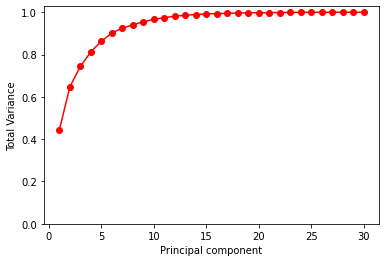

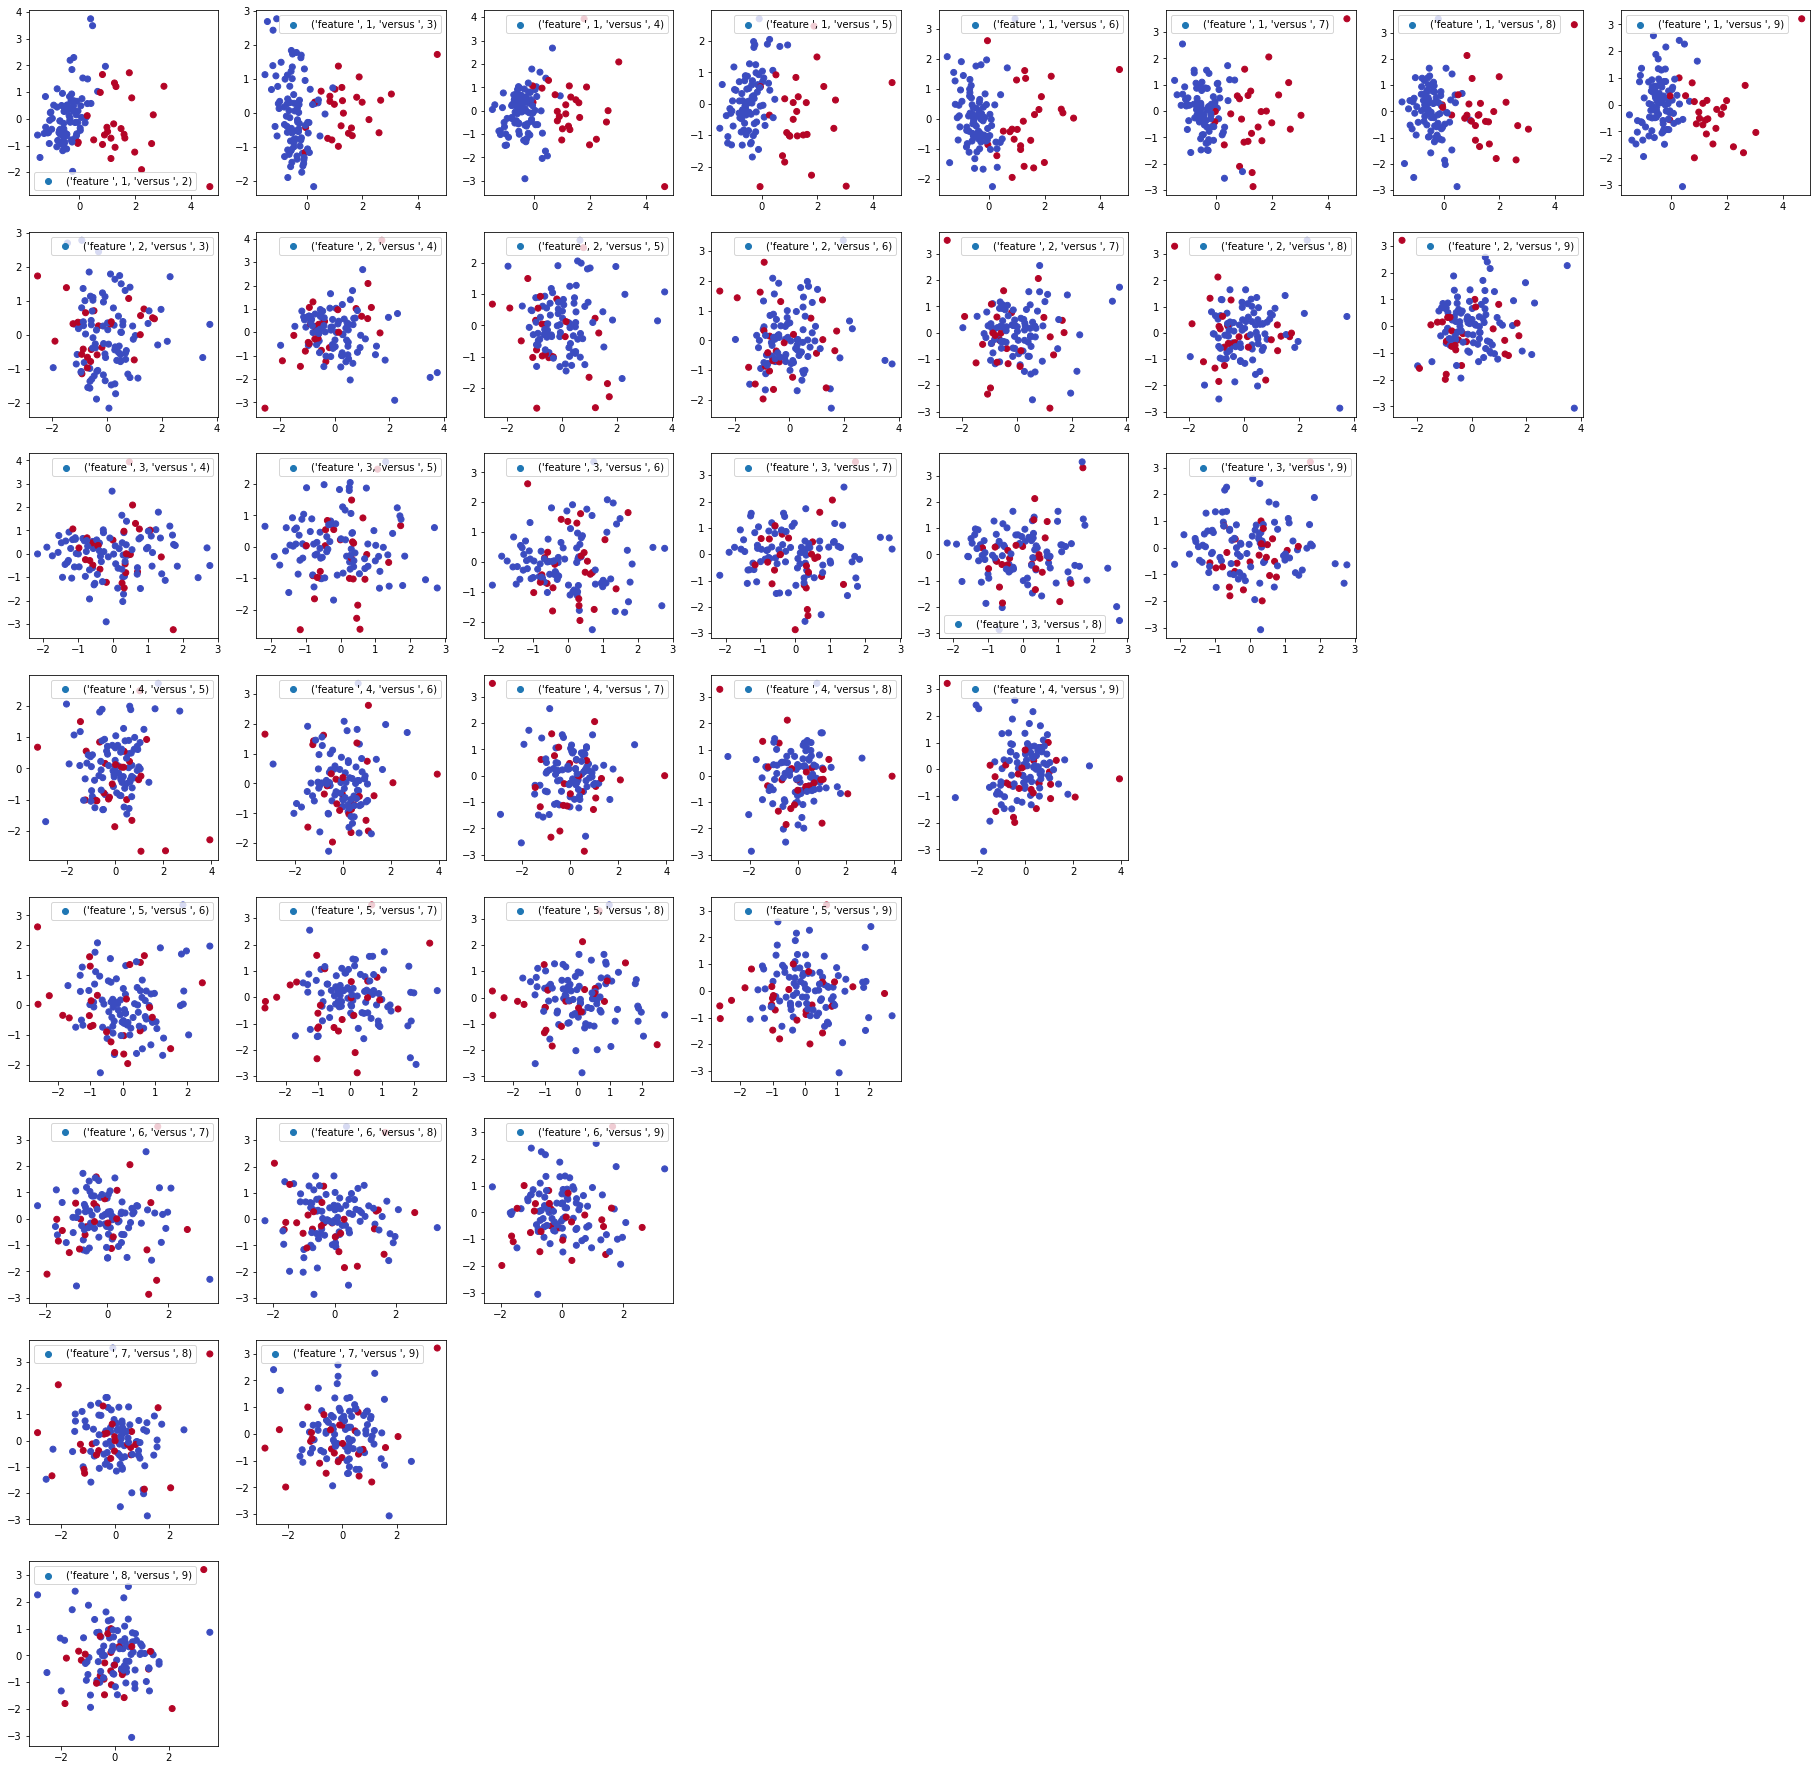

plots of clusters with pseudolabels


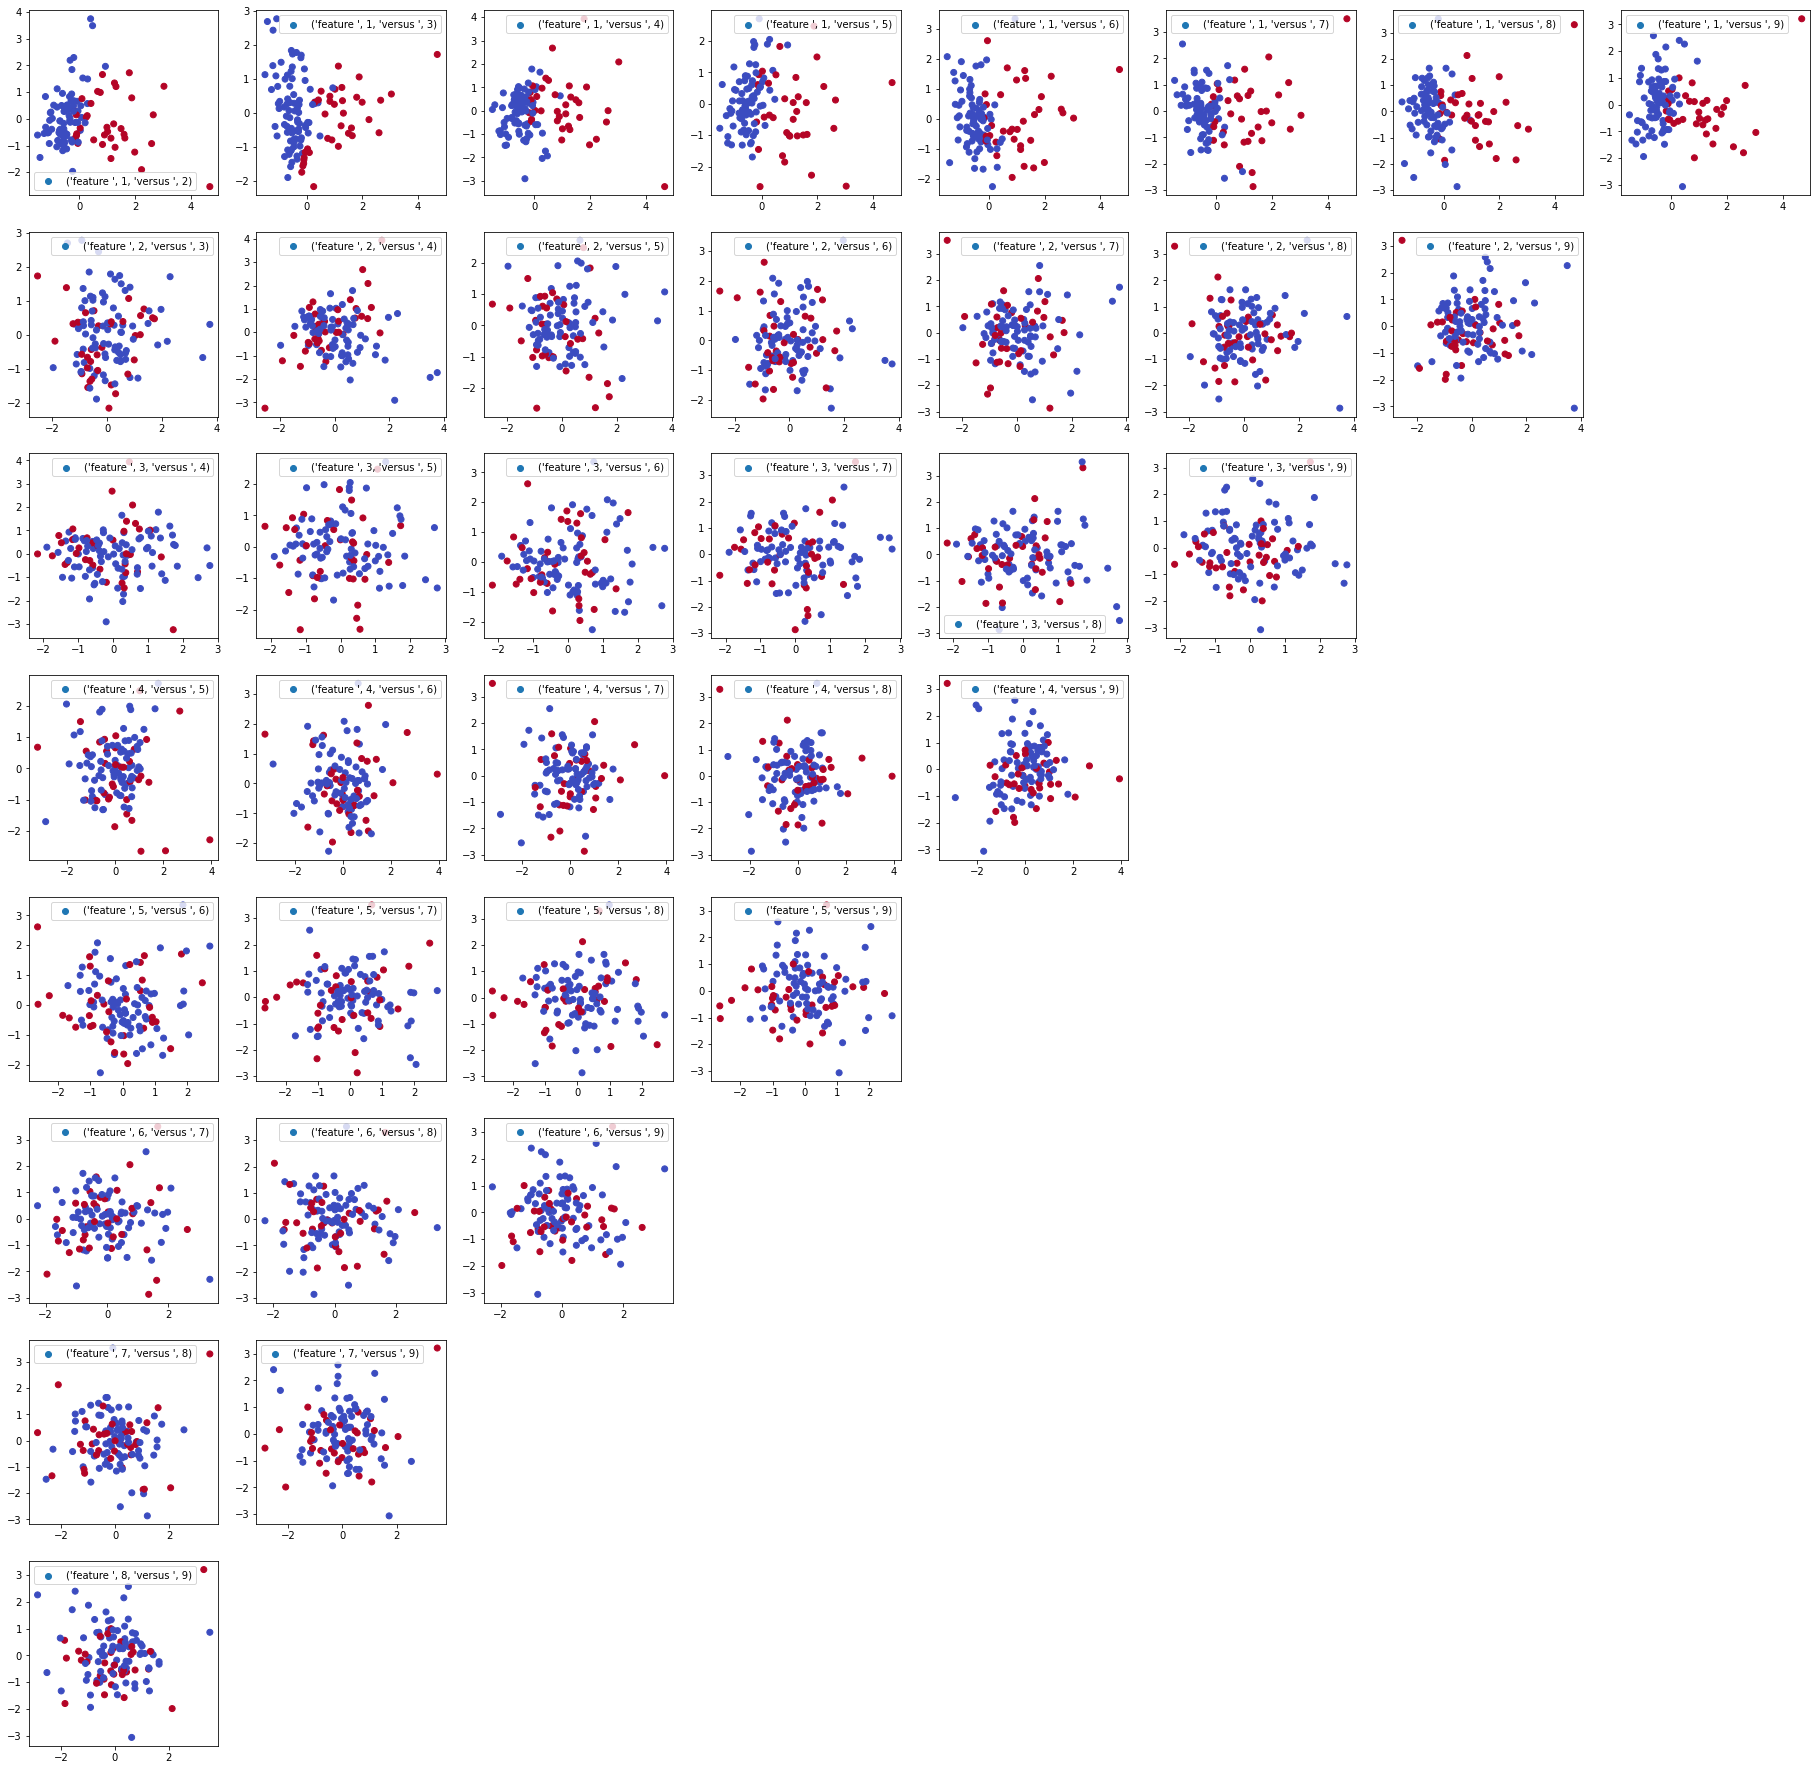

kmeans clustering accuracy is  0.907563025210084
inertia is  3698.906018629095


initializing gmm clustering
plots of clusters with true labels


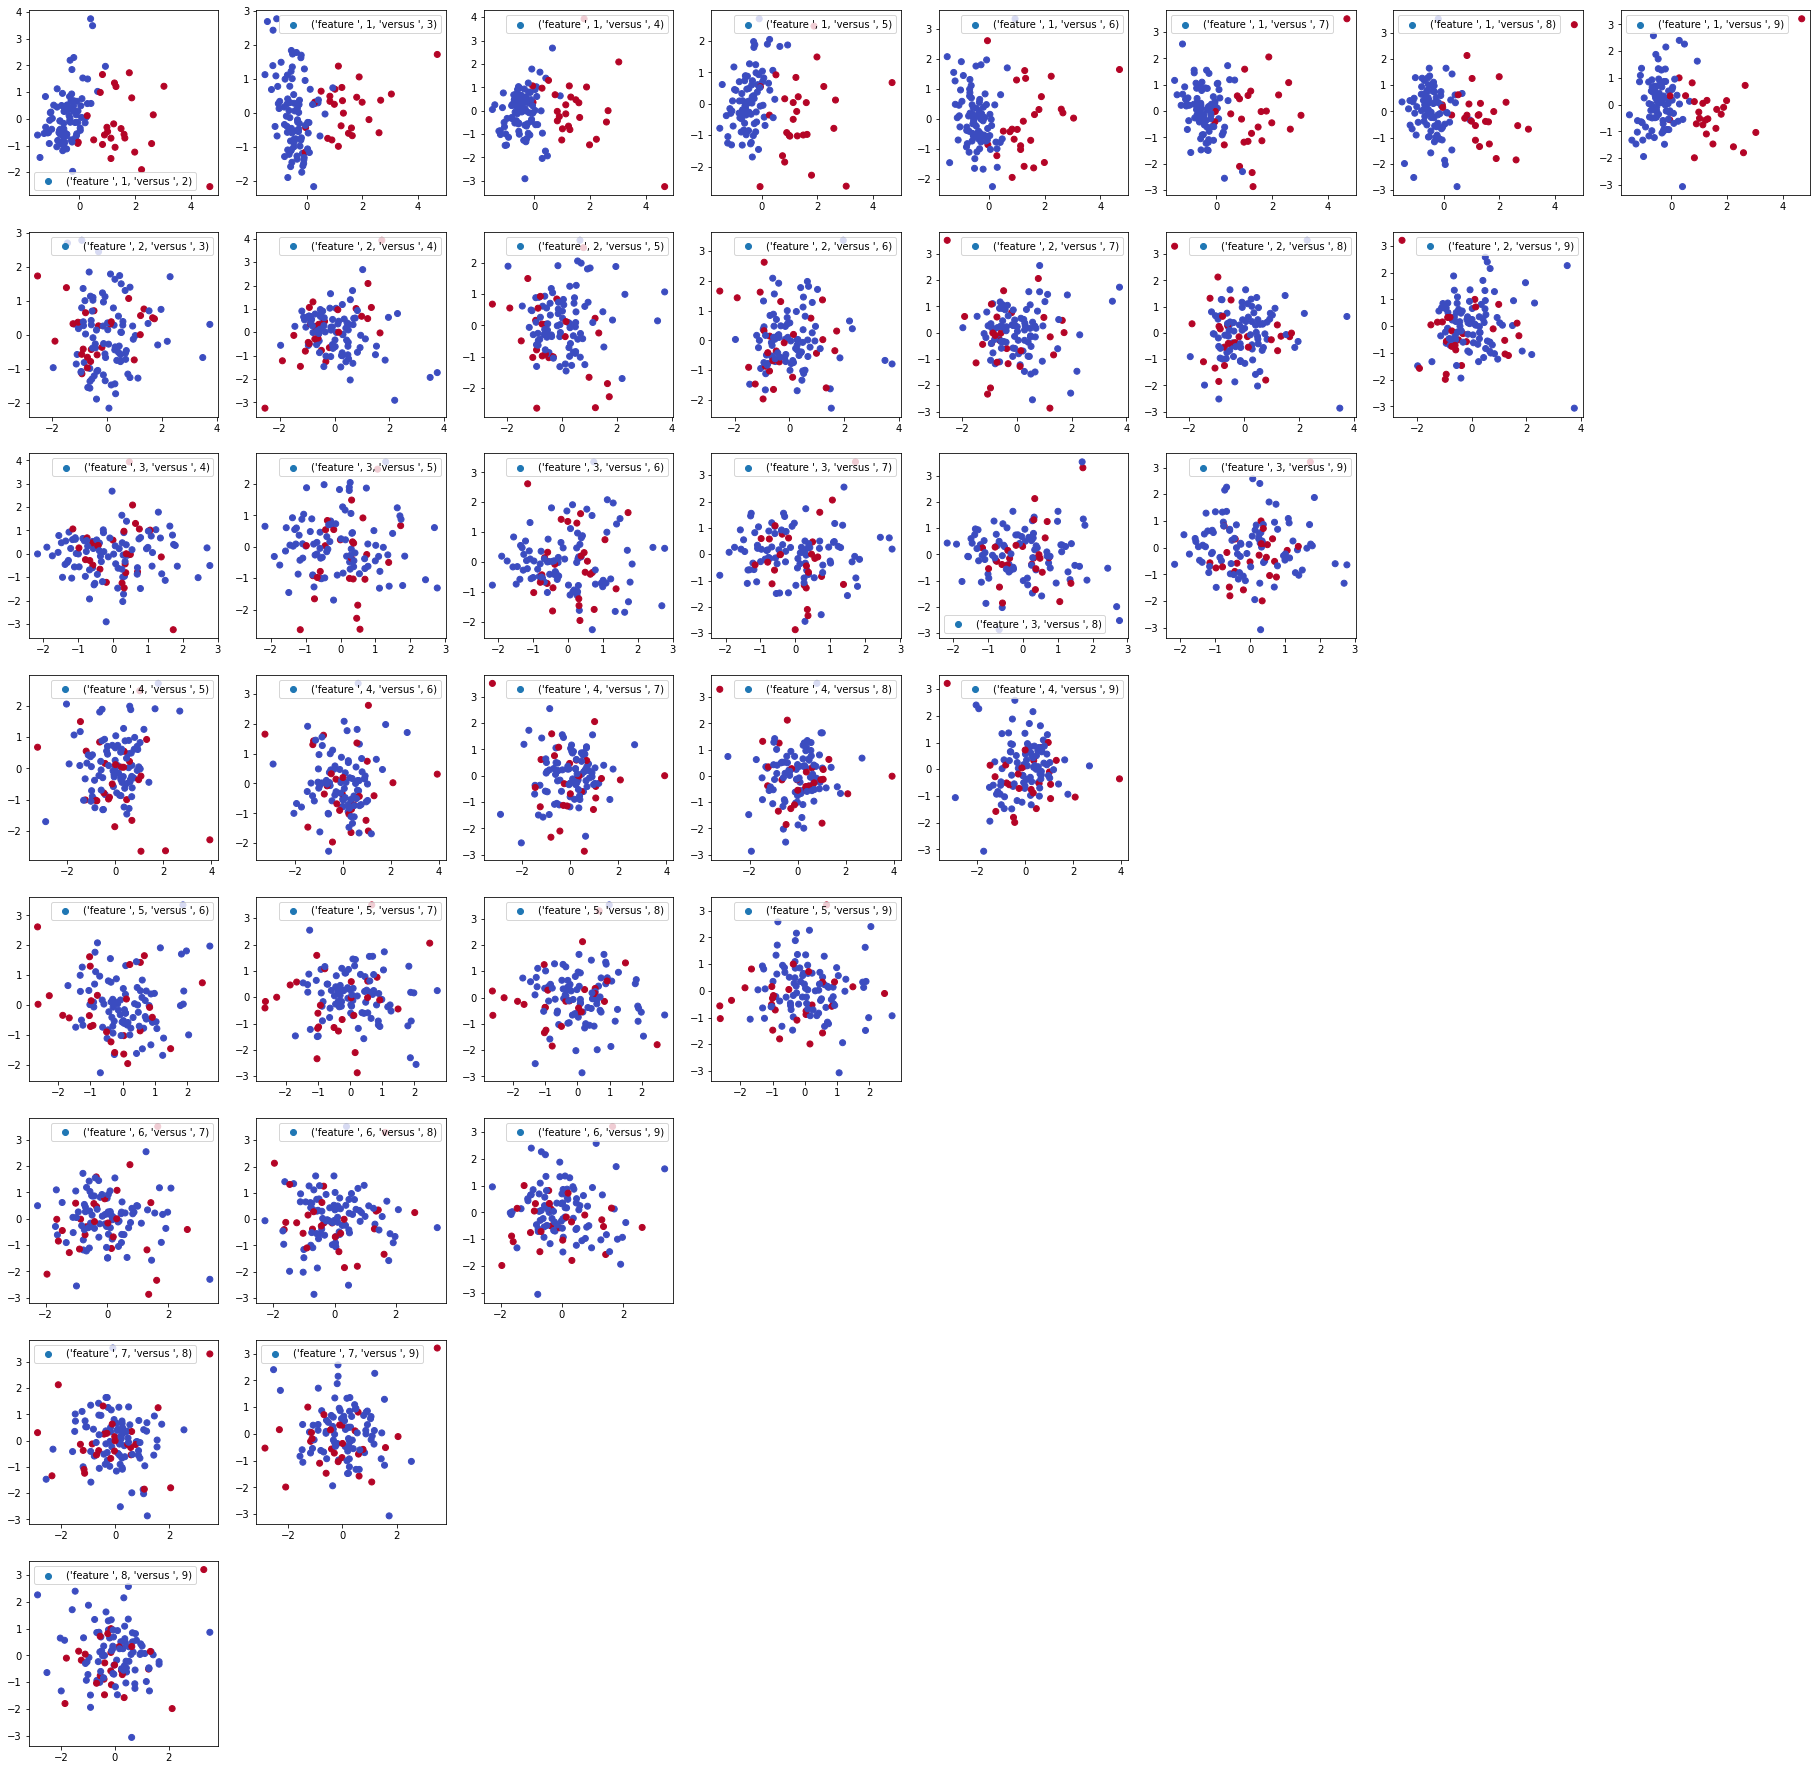

plots of clusters with pseudolabels


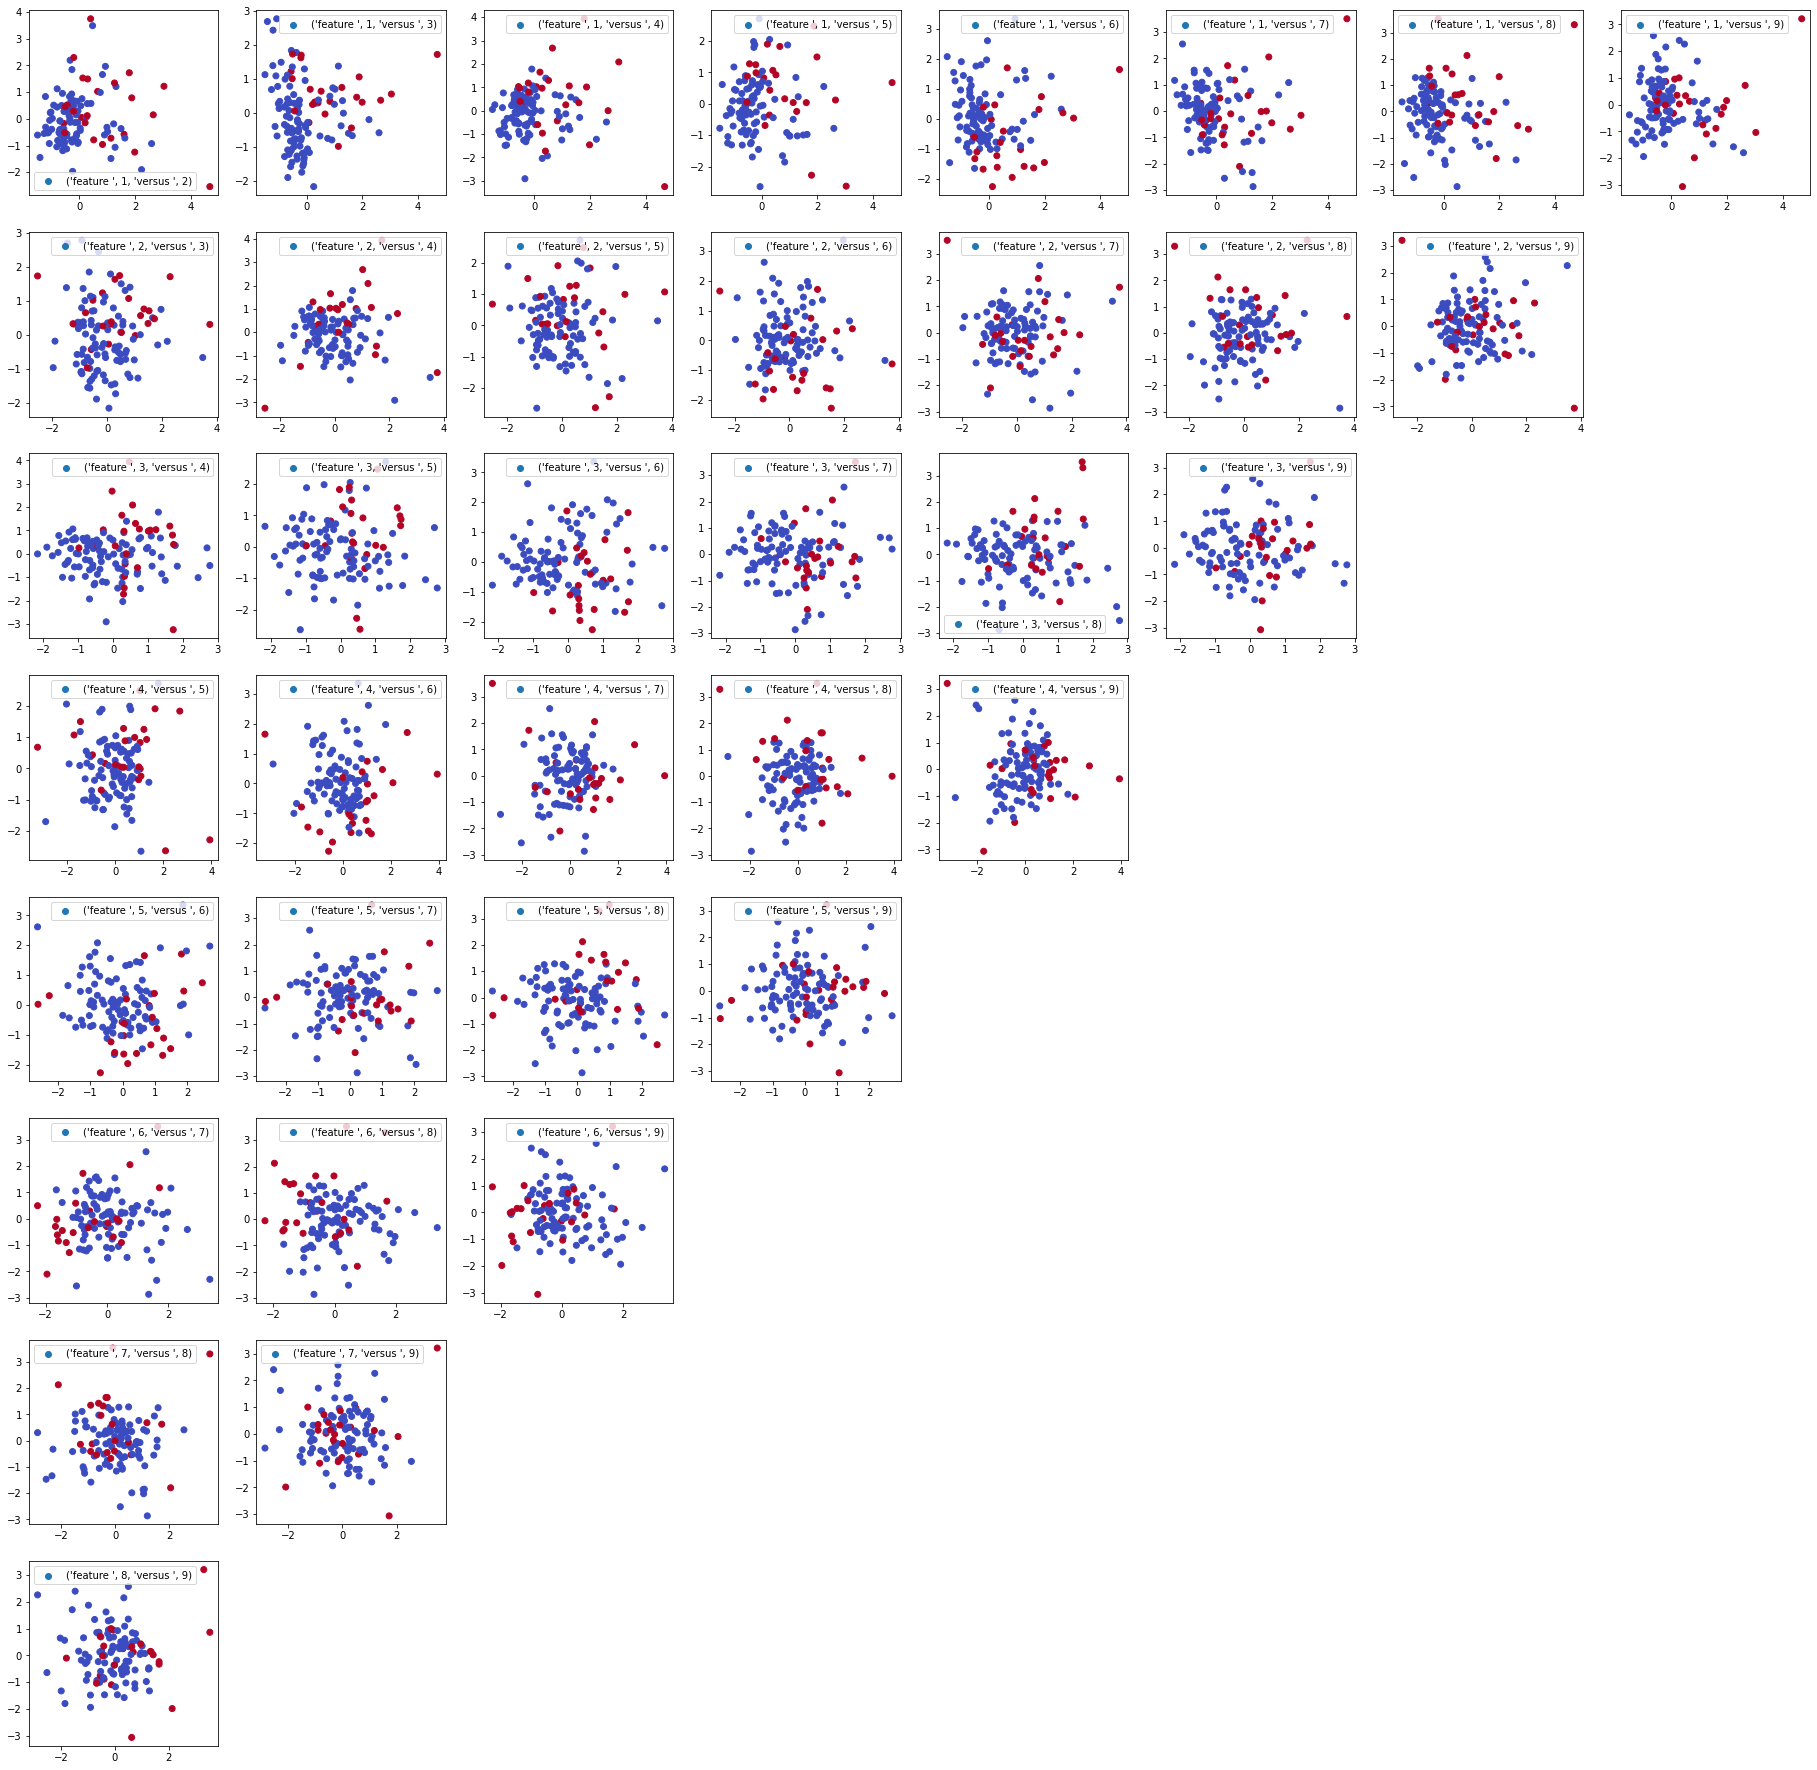

gmm clustering accuracy is  0.773109243697479
score is  -12.760435673715307


initializing spectral clustering with  gaussian
plots of clusters with true labels


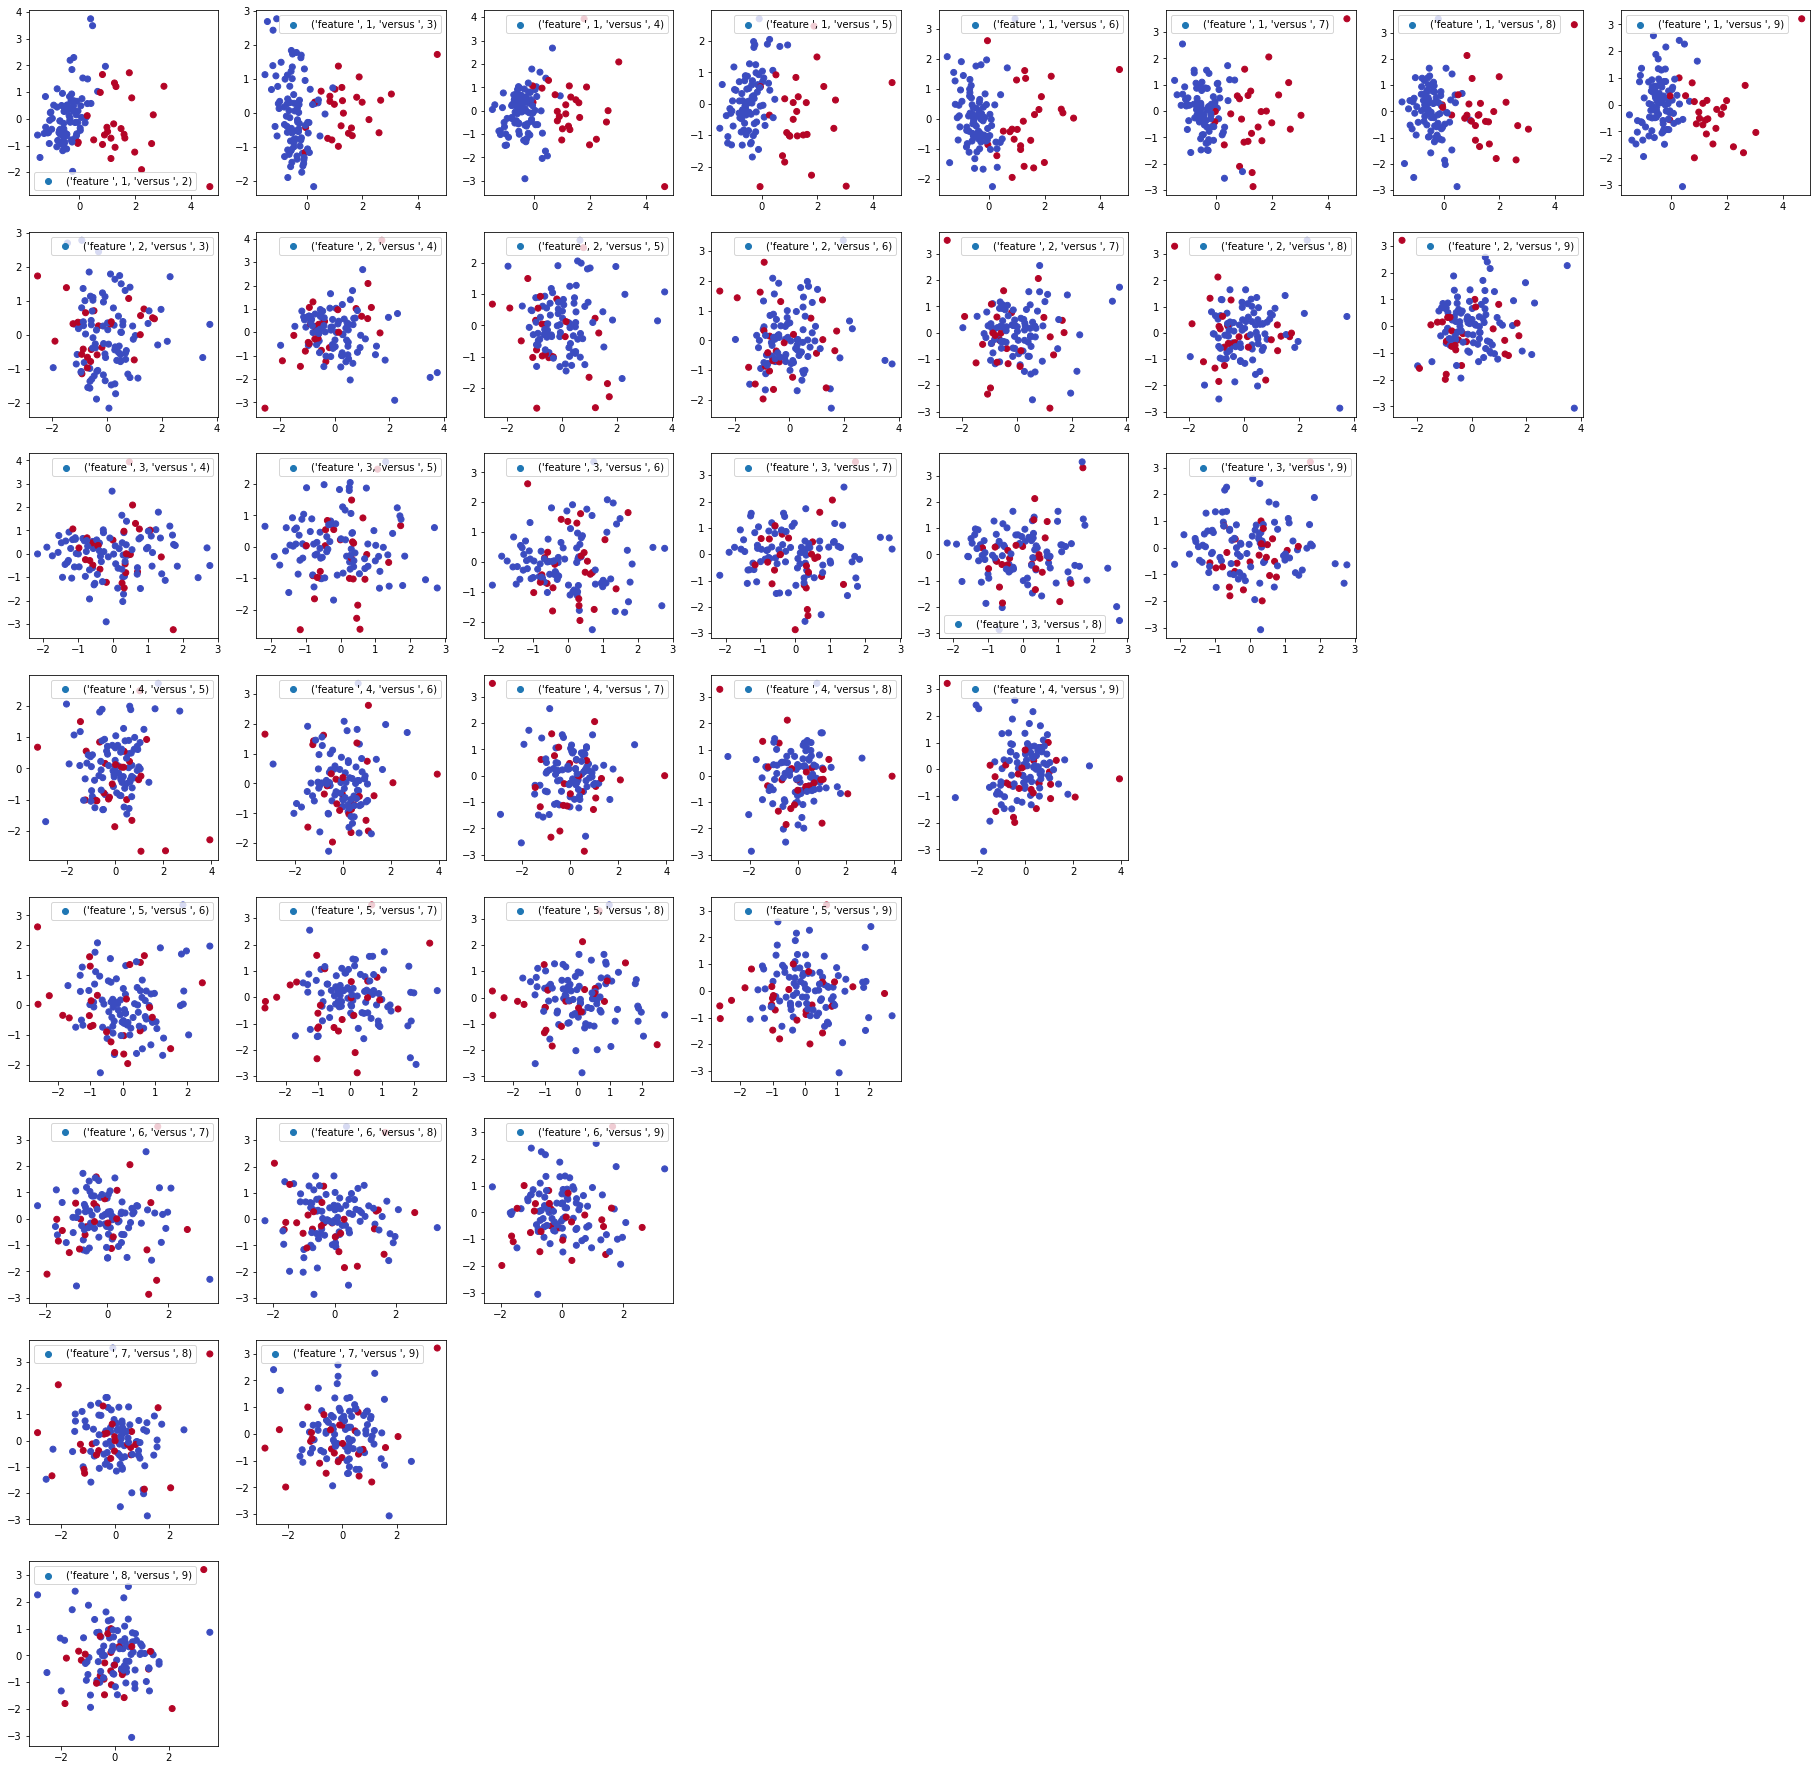

plots of clusters with pseudolabels


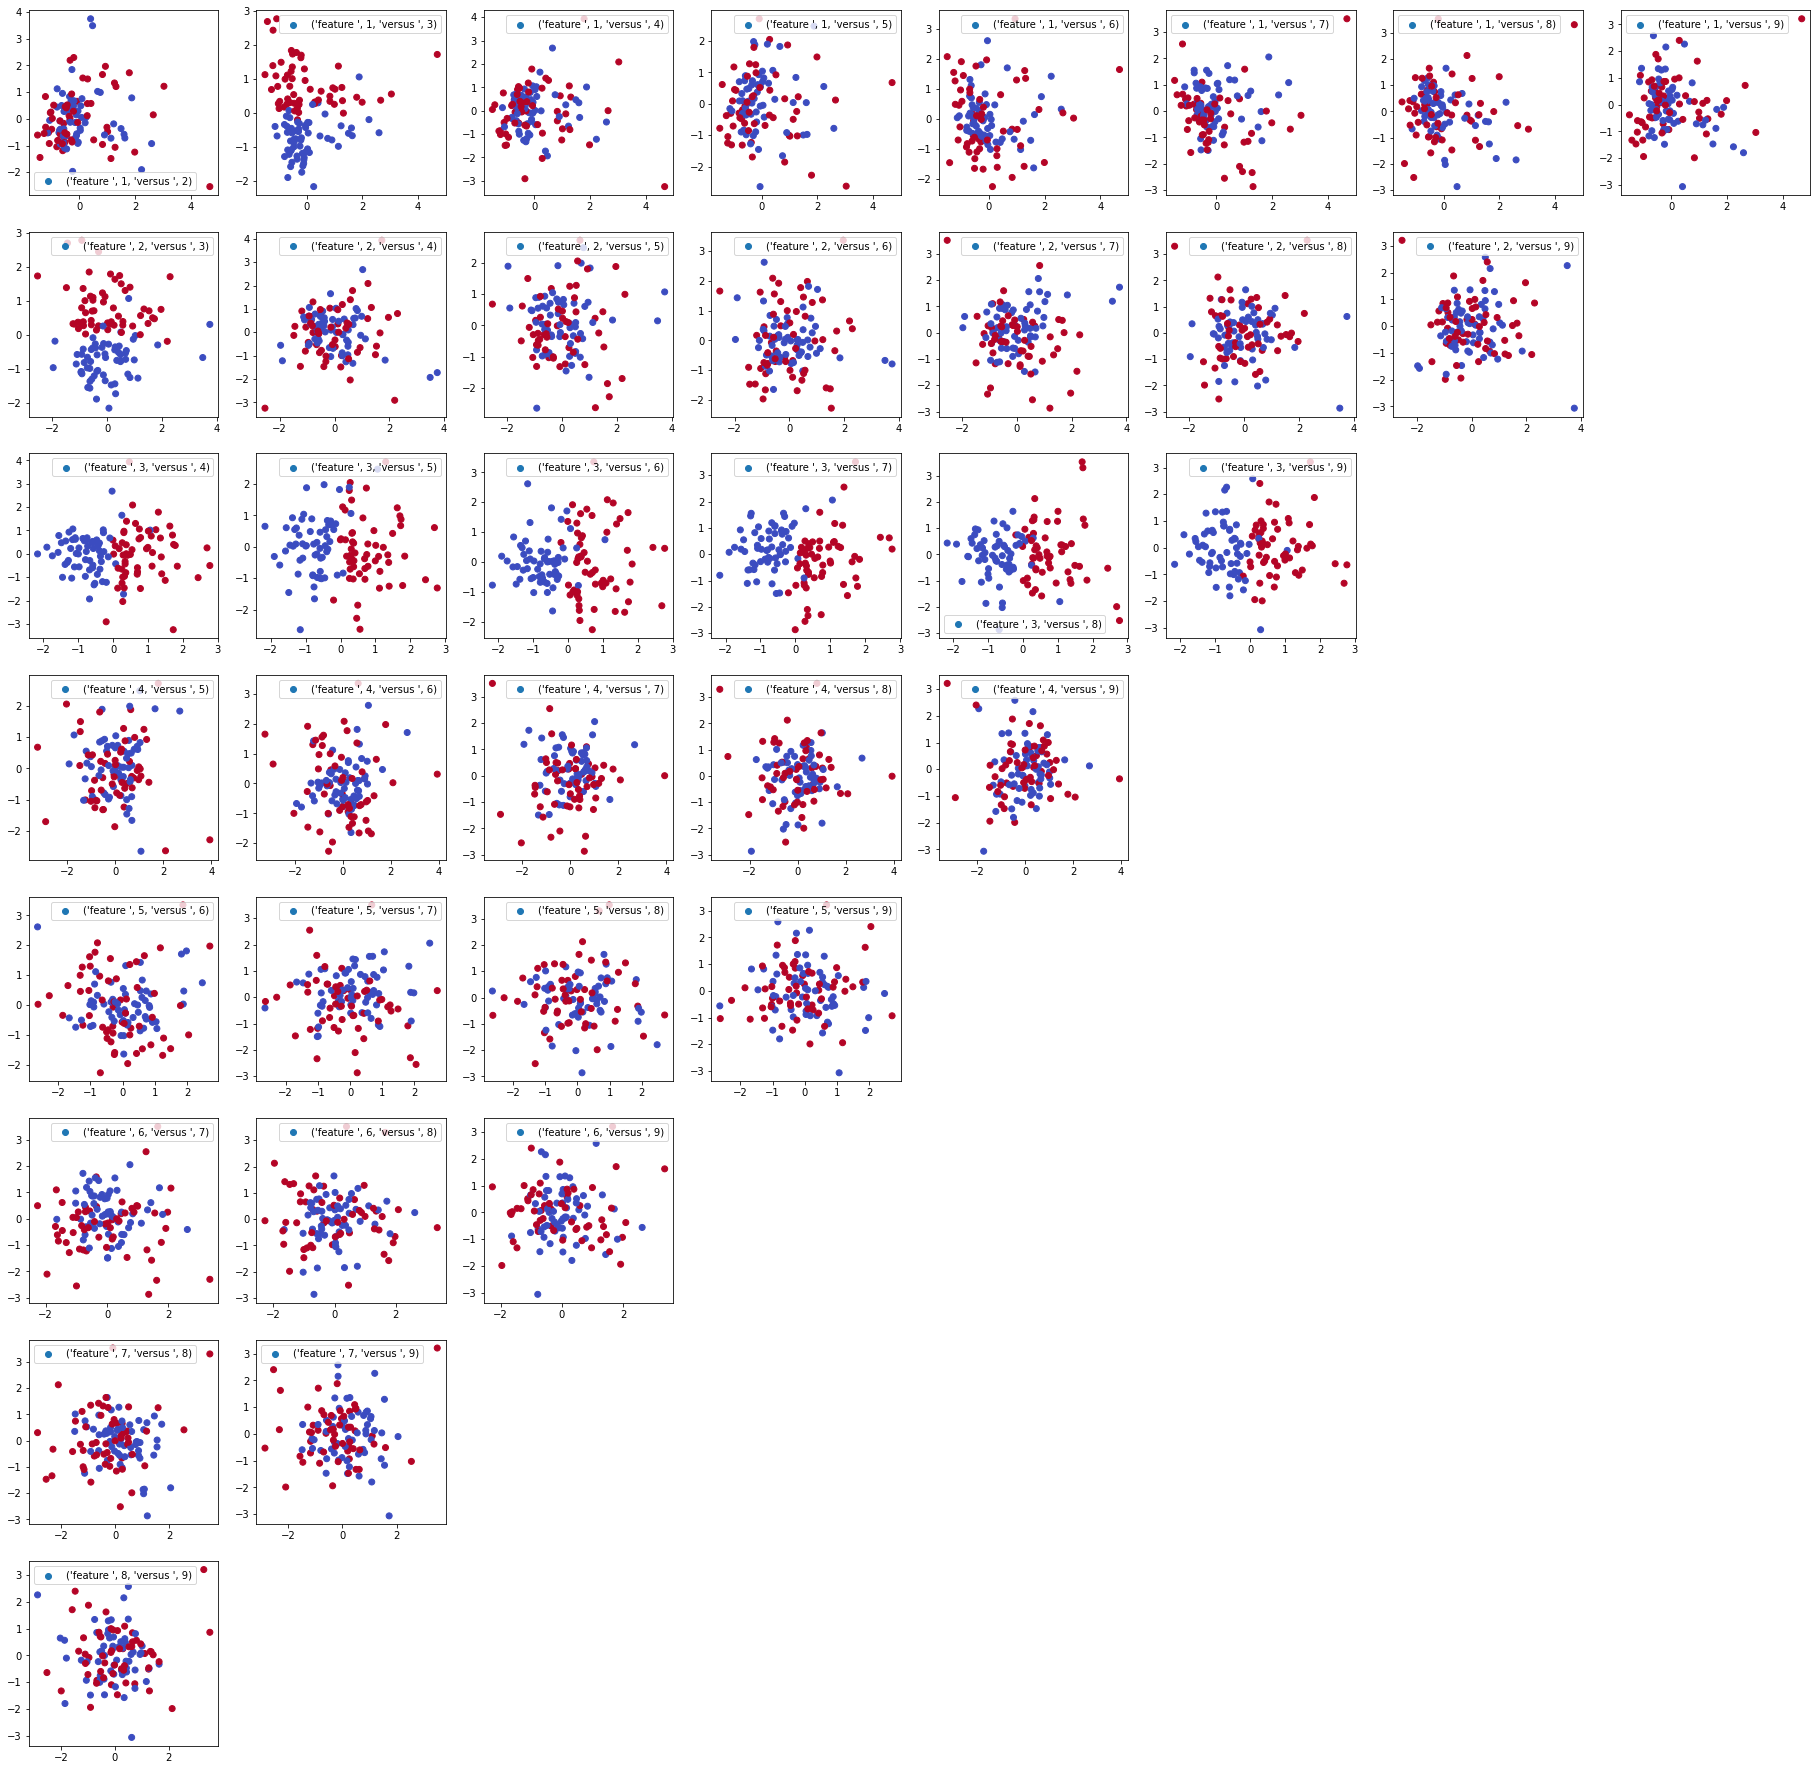

gaussian spectral clustering accuracy is  0.5462184873949579


initializing spectral clustering with  knn
plots of clusters with true labels


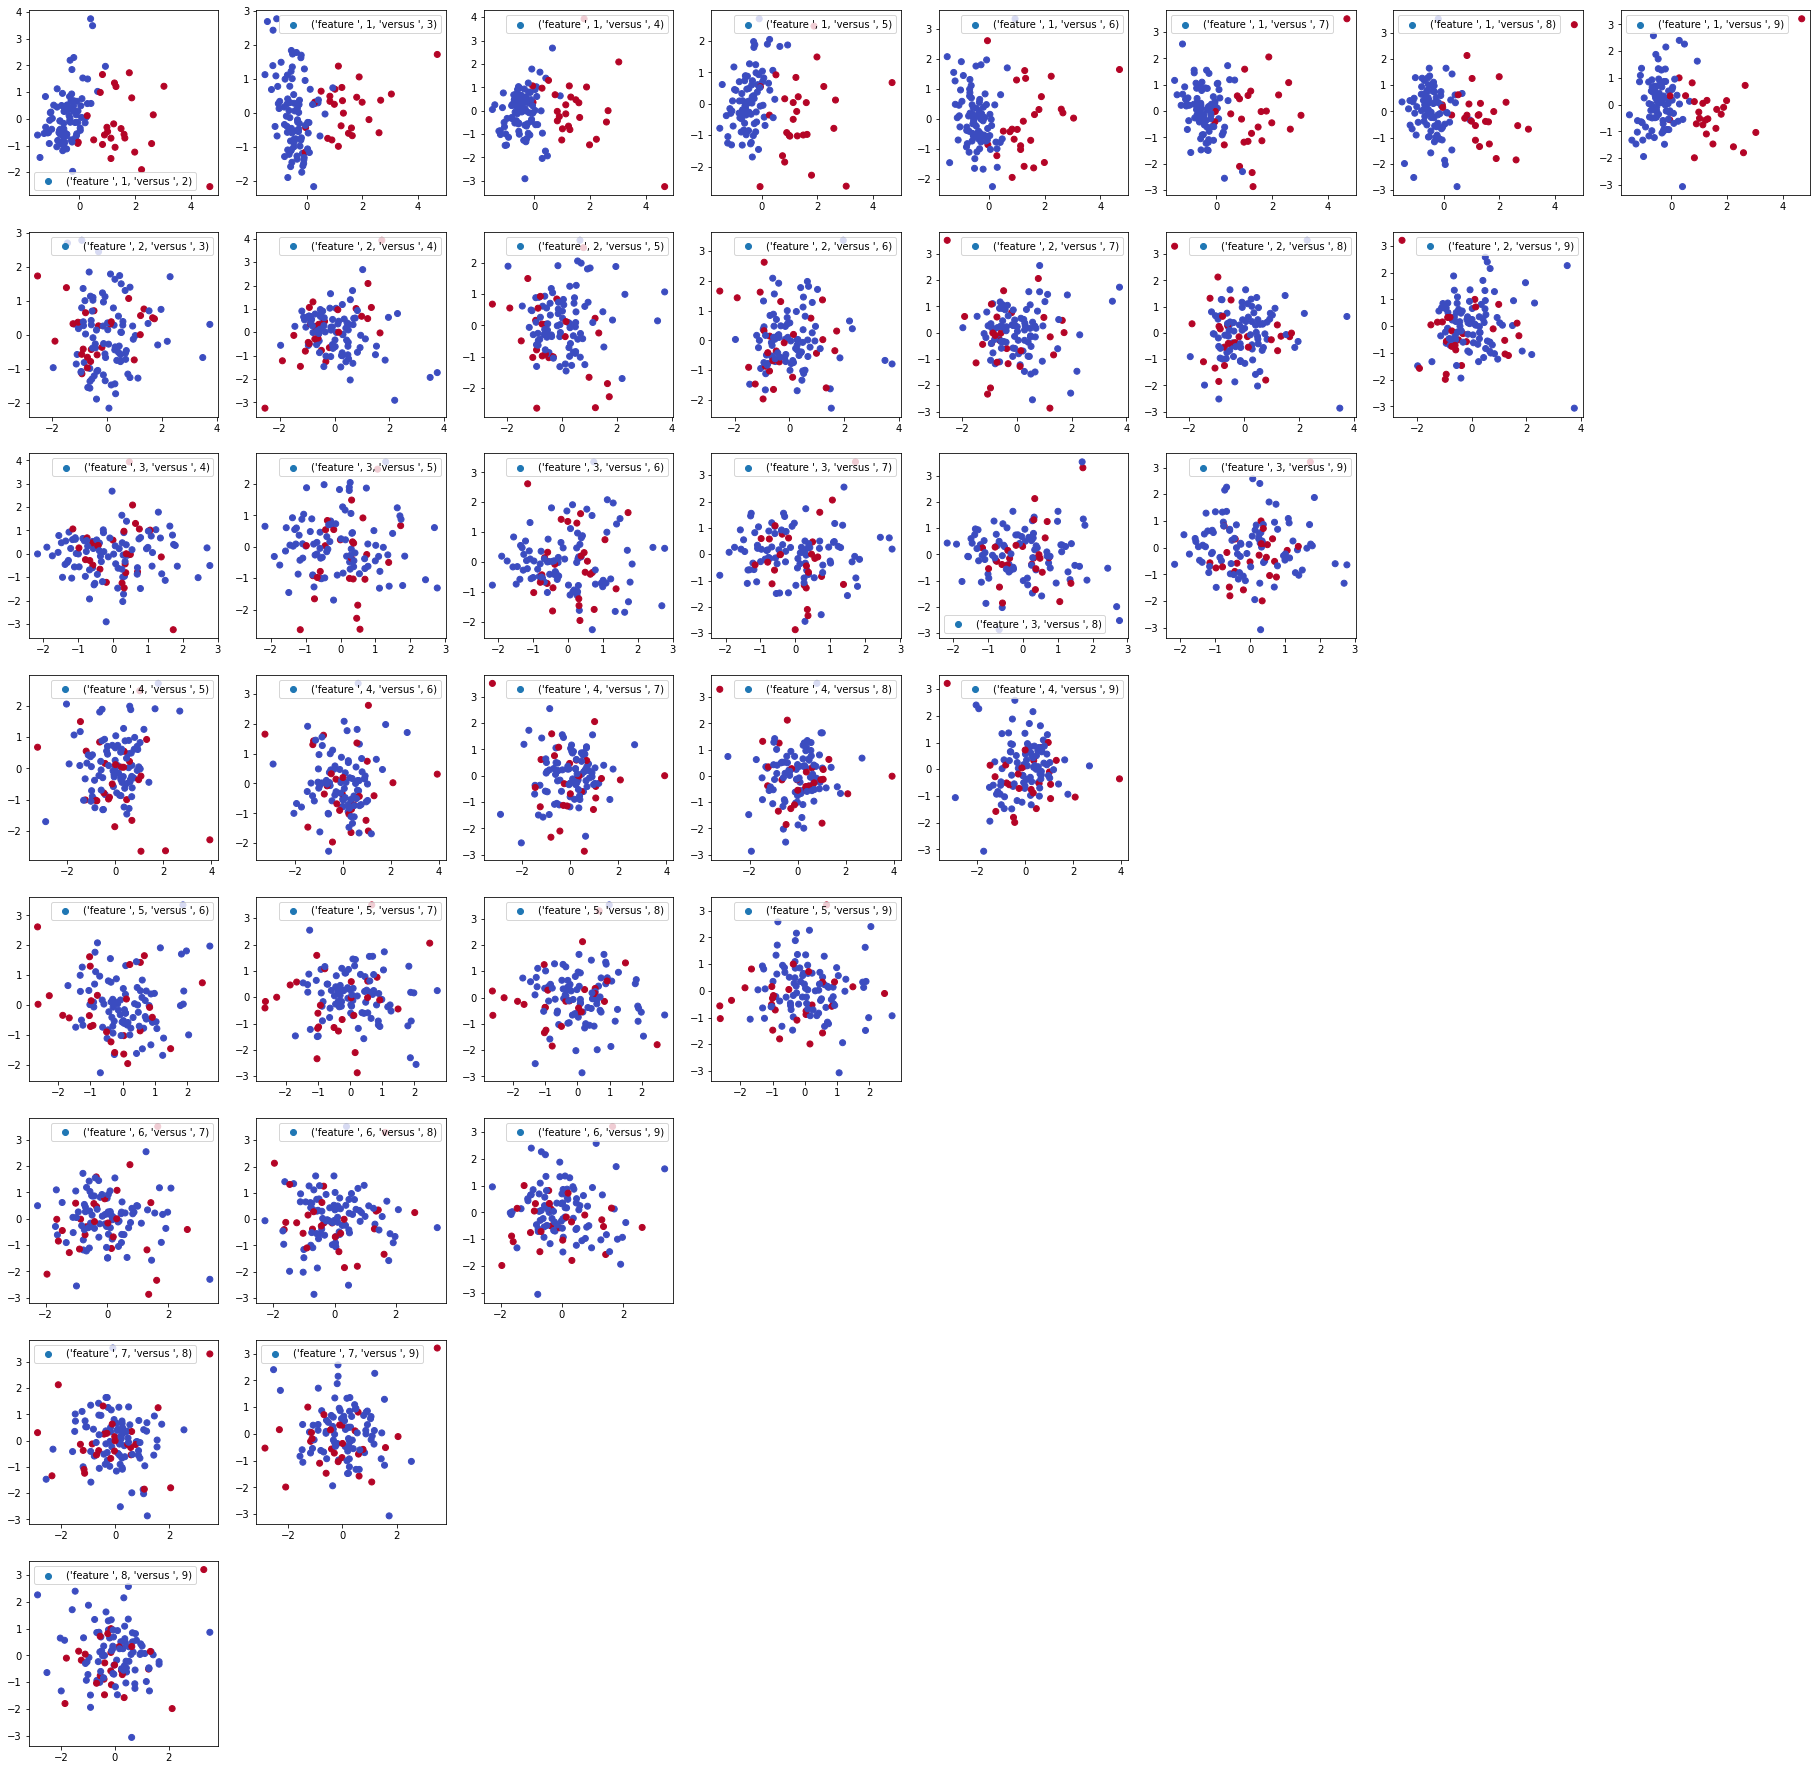

plots of clusters with pseudolabels


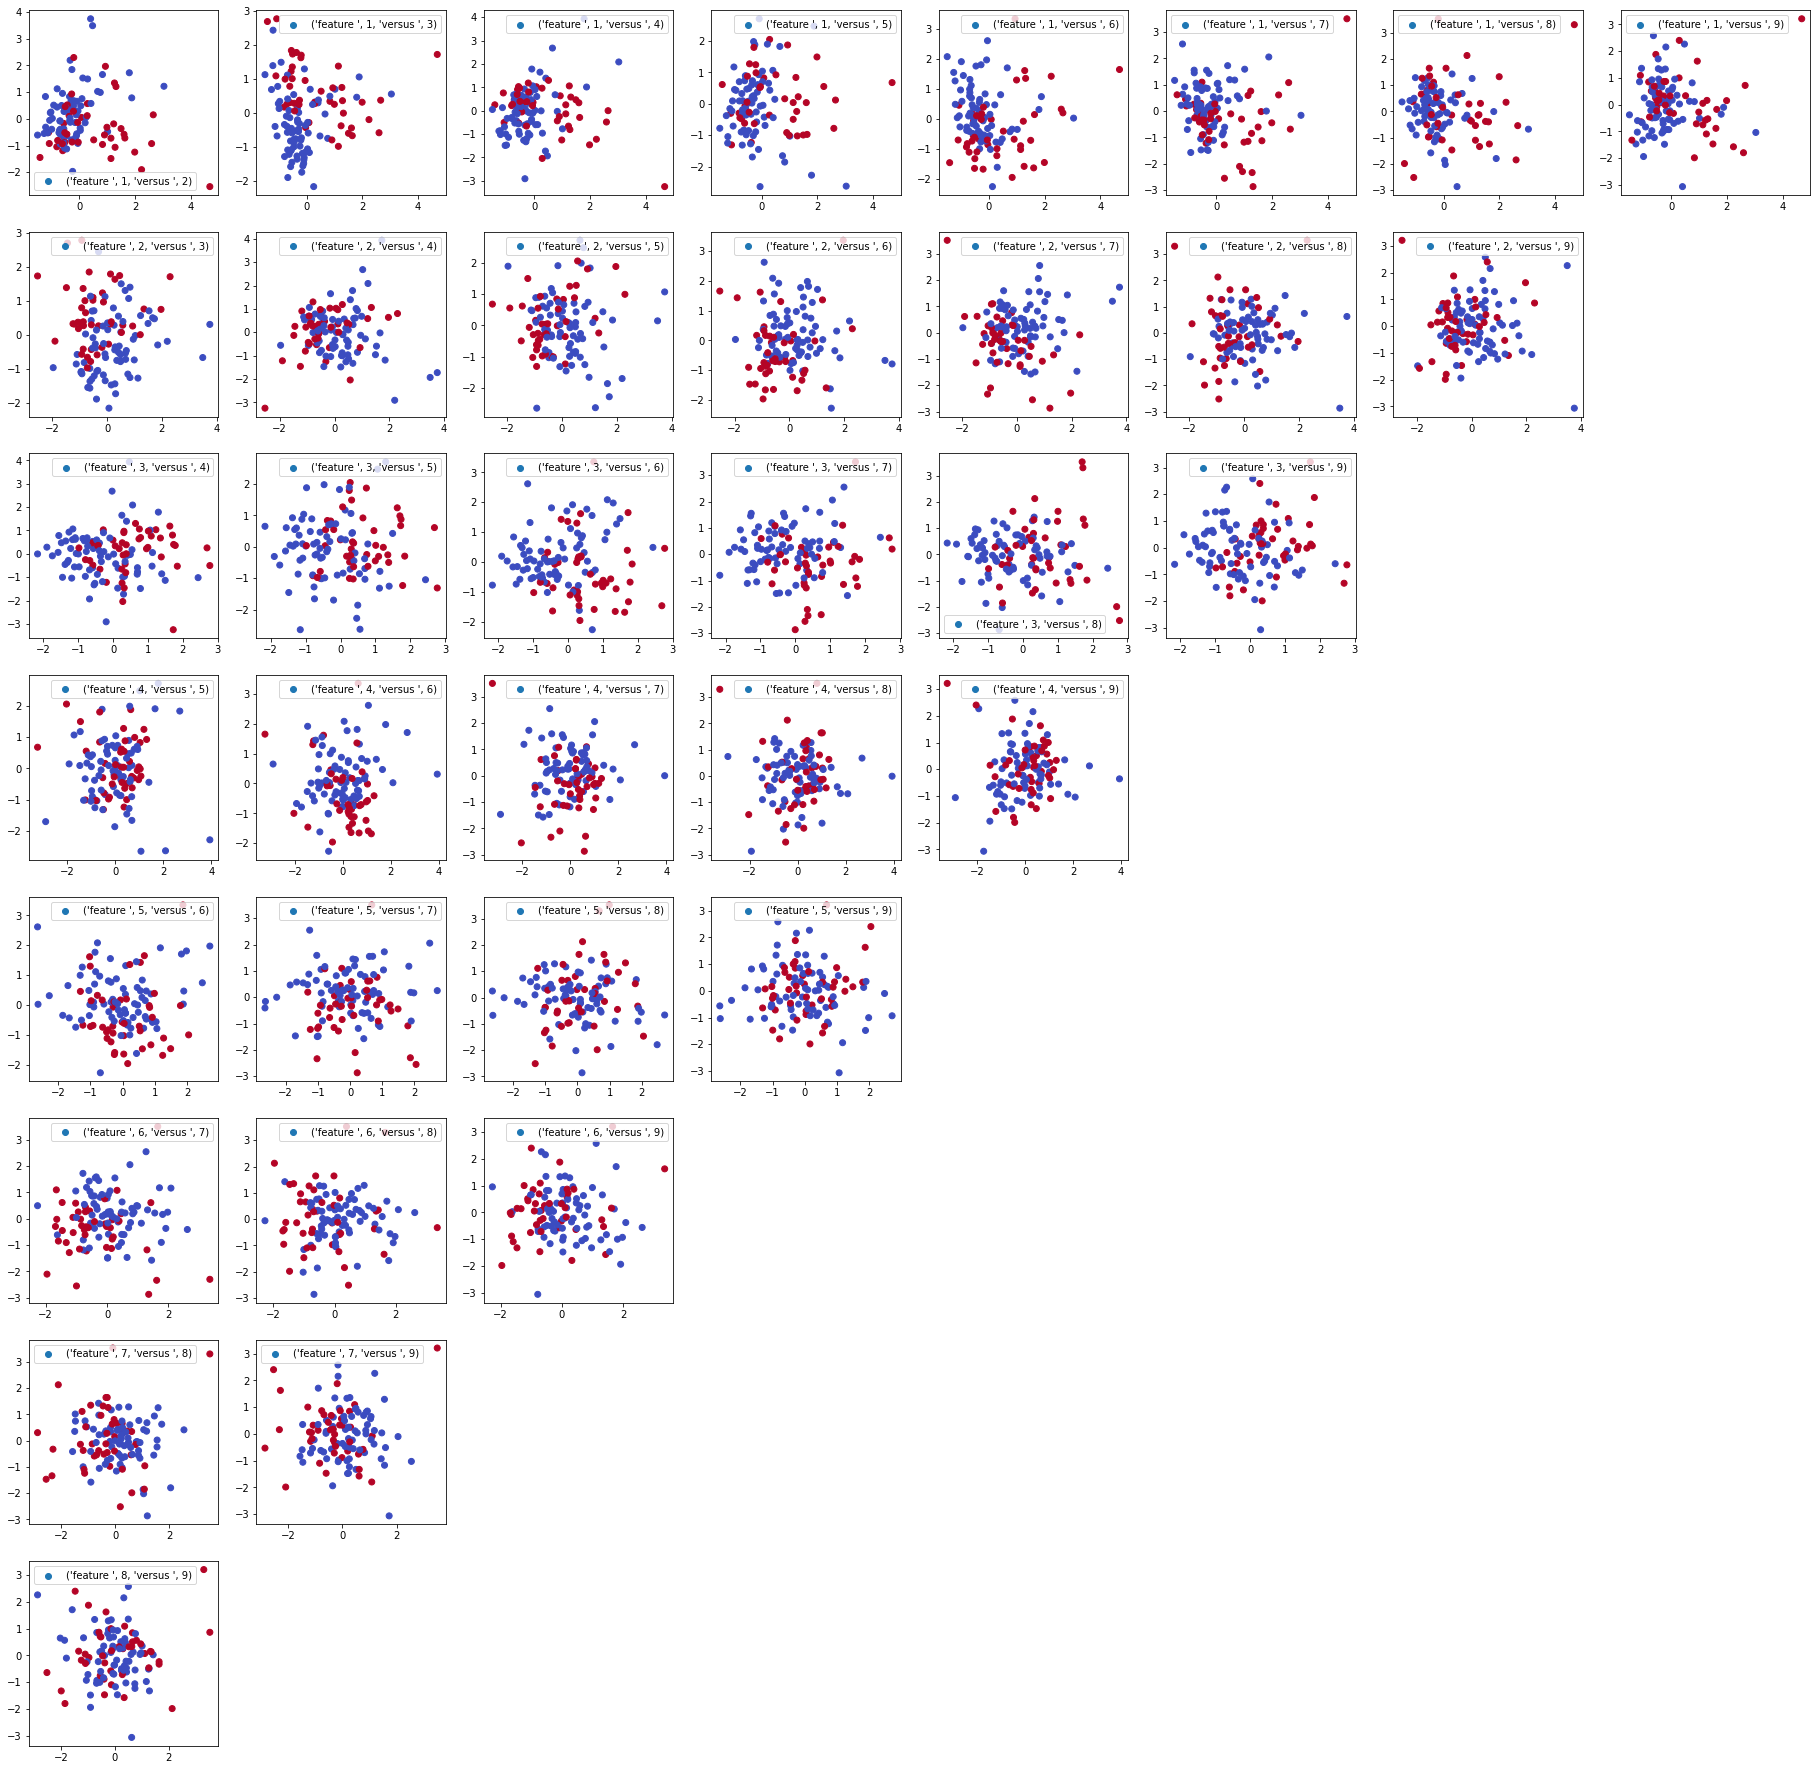

knn spectral clustering accuracy is  0.7394957983193278


In [43]:
# reformatting data.csv data
data_file = np.genfromtxt('data.csv', delimiter = ",", skip_header = True, dtype='str')
for i in range(len(data_file)):
  if data_file[i][1] == 'M':
    data_file[i][1] = 1
  elif data_file[i][1] == 'B':
    data_file[i][1] = 0
data_file = data_file.astype('float')
label = data_file[:450,1]
train_data = data_file[:450,2:]
data_id = data_file[:,0]
test_data = data_file[450:,2:]
test_label = data_file[450:,1]

print(data_file.shape)

scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
scaler = StandardScaler()
scaler.fit(test_data)
test_data = scaler.transform(test_data)

### hyperparameters
num_cluster = 2

experiment_main(num_cluster, train_data, test_data, label, test_label, preprocess=True, label_bool = True, plot_bool = True)

In [42]:
#@title 
#   unfinished code for finding optimal clusters 
#   def kmeans_clustering(data):
#   # the numbers of clusters to check
#   cluster_array = np.arange(1,20)
#   # list of kmeans models for each # of cluster in cluster_array
#   score = []
#   for i in cluster_array:
#     kmeans = KMeans(init='random', n_clusters=i, n_init=100) 
#     # list of scores from kmeans method (negative sum of distance squared from cluster center)
#     cluster_labels = kmeans.fit_predict(X)
#     score.append(kmeans.fit(data).score(data))

#   plt.plot(cluster_array, score)

#   # figure(figsize=(6,6)); ax=subplot(aspect='equal')
#   # scatter(X[:,0],X[:,1],c=kmeans.labels_,cmap=cm.rainbow);

#   # C = kmeans.cluster_centers_
#   # scatter(C[:,0],C[:,1],c='k',marker='o',s=300,alpha=0.5,edgecolor='none')







# # uses KFold to get a 80/20 train/test split
# k_fold = KFold(n_splits=5, shuffle=True) 
# for k, (train, test) in enumerate(k_fold.split(X)):
#   train_data = data[train]
#   test_data = data[test]
#   train_label = label[train]
#   test_label = label[test]
#   break














# # standardization with 0 mean and 1 stdev
# scaler = StandardScaler()
# scaler.fit(data)
# data = scaler.transform(data)